# CHANGES IN THE NOTEBOOK

1.   KERAS DATASET IS USED
2.   AUGMENTATION IS REMOVED
3.   MODEL IS  STILL DEFINED USING tf.nn BUT CHANGED A BIT 



# OBSERVATION MADE


1.   Kronecker product preconditioning training loss start increasing after some iterations



In [1]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY'
sys.path.append(base_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import preconditioned_stochastic_gradient_descent as psgd 
from tabulate import tabulate
import scipy.io

## Download MNIST Data

In [5]:
"""MNIST, classification"""
np.random.seed(0)

# Parameter Settings
batch_size = 128
num_f = 32  # number of features 

dtype = tf.float32

mnist = tf.contrib.learn.datasets.load_dataset('mnist')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-u

In [6]:
# Load the FashionMNIST dataset, scale the pixel values
(train_data, train_label0), (test_data, test_label0) = tf.keras.datasets.mnist.load_data()
train_data =train_data/255.
test_data = test_data/255.

train_data.shape, test_data.shape, train_label0.shape, test_label0.shape

train_data = train_data.astype("float32").reshape(-1, 28, 28, 1)
test_data = test_data.astype("float32").reshape(-1, 28, 28, 1)

#binarize the labels
train_label = np.zeros([60000, 10])
test_label = np.zeros([10000, 10])
train_label[np.arange(60000),  train_label0] = 1.0
test_label[np.arange(10000),  test_label0] = 1.0
print(train_label.shape)
print(test_label.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 10)
(10000, 10)


In [0]:
def get_batches():
    # generate 60000 numbers randomly without replacement
    rp = np.random.permutation(train_data.shape[0])
    x = -np.ones([batch_size, 28, 28, 1])
    
    # augumentation: randomly shifting image by +-2 pixels 
    for i in range(batch_size):
        x[i] = train_data[rp[i]]
    y = train_label[rp[0:batch_size]]
    return x, y

## Defining CNN model for training.
The model consists of 2 convolutional layers, 1 avgpool layer, 2 convolutional layers, 1 avg pool layer, 1 FC layer, 1 FC layer.

In [0]:
train_inputs = tf.placeholder(dtype, [batch_size, 28, 28, 1])
train_outputs = tf.placeholder(dtype, [batch_size, 10])
adam_step = tf.placeholder(tf.float32, shape = ())

In [0]:
# (hight, width, in_ch, out_ch) tensor --> (hight * width * in_ch, out_ch) matrix 
W1 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*1+1), size=[3*3*1+1, num_f]), dtype=dtype)
W2 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W3 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W4 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W5 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(4*4*num_f+1), size=[4*4*num_f+1, 10]), dtype=dtype)
Ws = [W1, W2, W3, W4, W5]

# we use the traditional tanh
def model(Ws, inputs):
    
    W1, W2, W3, W4, W5 = Ws
    w1 = tf.reshape(W1[:-1], [3, 3, 1, num_f])
    b1 = W1[-1]
    x1 = tf.tanh( tf.nn.conv2d(input = inputs,filters = w1, strides = [1,1,1,1], padding = 'VALID') + b1 )
    
        
    w2 = tf.reshape(W2[:-1], [3, 3, num_f, num_f])
    b2 = W2[-1]
    x2 = tf.tanh( tf.nn.conv2d(input = x1, filters = w2, strides = [1,1,1,1], padding = 'VALID') + b2 )
    
    x2 = tf.nn.avg_pool(value = x2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        
    w3 = tf.reshape(W3[:-1], [3, 3, num_f, num_f])
    b3 = W3[-1]
    x3 = tf.tanh( tf.nn.conv2d(x2, w3, [1,1,1,1], 'VALID') + b3 )
        
    w4 = tf.reshape(W4[:-1], [3, 3, num_f, num_f])
    b4 = W4[-1]
    x4 = tf.tanh( tf.nn.conv2d(x3, w4, [1,1,1,1], 'VALID') + b4 )
    
    x4 = tf.nn.avg_pool(value = x4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

    batch_size = inputs.shape.as_list()[0]
    x4_flat = tf.reshape(x4, [batch_size, -1])
    ones = tf.ones([batch_size, 1], dtype=dtype)

    y = tf.matmul(tf.concat([x4_flat, ones], axis = 1), W5)
    return y

## Define cross entropy as Training Loss function (Loss function) and Test Loss function

In [0]:
# cross entropy loss
def train_criterion(Ws):
    y = model(Ws, train_inputs)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=train_outputs, logits=y))

# classification error rate
def test_criterion(Ws):
    y = model(Ws, tf.constant(test_data, dtype=dtype))
    # return 1 - accuracy 
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=test_label, logits=y))
    # return 1.0 - tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), tf.constant(mnist.test.labels, dtype=tf.int64)), dtype=dtype))

# SGD

train loss: 2.3460693359375; test loss: 2.3370020389556885; time:5.801565170288086
train loss: 1.9664665180563927; test loss: 1.487282395362854; time:6.845057725906372
train loss: 1.4076660818549804; test loss: 0.8440873026847839; time:7.867939710617065
train loss: 0.970226475083328; test loss: 0.6262035369873047; time:8.896689653396606
train loss: 0.730278021914976; test loss: 0.531858503818512; time:9.938967943191528
train loss: 0.5999058695130038; test loss: 0.4798286557197571; time:10.983821392059326
train loss: 0.523443781070629; test loss: 0.44377437233924866; time:12.012633085250854
train loss: 0.47267127052860675; test loss: 0.4182661473751068; time:13.045645713806152
train loss: 0.44345687544754675; test loss: 0.3986765146255493; time:14.070345640182495
train loss: 0.42695062510022636; test loss: 0.3829162120819092; time:15.096734285354614
train loss: 0.4118573106153392; test loss: 0.36892154812812805; time:16.148710250854492
train loss: 0.39064611258825416; test loss: 0.35777

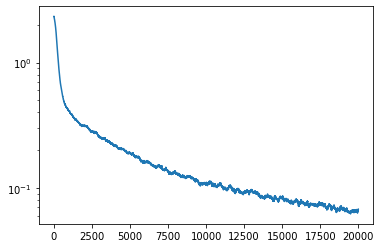

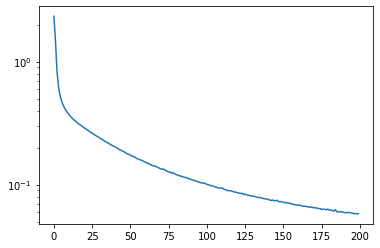

In [11]:
step_size = 0.01
grad_norm_clip_thr = 1e0 # may need gradients cliping for RNN training; otherwise, set it to an extremely large value  

with tf.Session() as sess:
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    test_loss = test_criterion(Ws)

    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _ = sess.run([train_loss, update_Ws],
                                  {train_inputs: _train_inputs, train_outputs: _train_outputs})     
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; time:{}'.format(TrainLoss[-1],TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

 
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/SGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# ADAM

train loss: 2.3277318477630615; test loss: 2.326958179473877; Time: 0.11149001121520996
train loss: 0.4038607748433948; test loss: 0.19481365382671356; Time: 1.2734401226043701
train loss: 0.24017939615974462; test loss: 0.10293898731470108; Time: 2.417267322540283
train loss: 0.1487829976835664; test loss: 0.0897301584482193; Time: 3.5606205463409424
train loss: 0.1117056413389056; test loss: 0.06140755116939545; Time: 4.701897859573364
train loss: 0.08006872147034662; test loss: 0.06189240142703056; Time: 5.84977912902832
train loss: 0.07208708288781304; test loss: 0.06133550405502319; Time: 6.993194818496704
train loss: 0.06100293636408122; test loss: 0.049192123115062714; Time: 8.124362230300903
train loss: 0.06020186278326005; test loss: 0.05631210282444954; Time: 9.254693031311035
train loss: 0.05305538936309689; test loss: 0.046217046678066254; Time: 10.382709503173828
train loss: 0.048836674567588535; test loss: 0.04215392842888832; Time: 11.517975807189941
train loss: 0.048218

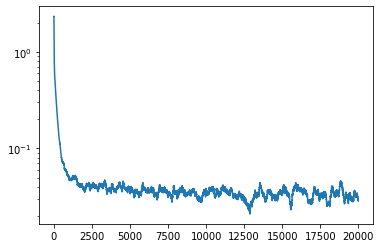

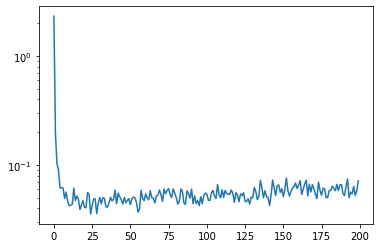

In [12]:
# Adam 
step_size = 0.005
beta1 = 0.9
beta2 = 0.999
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_moment = [beta1*m + (1.0 - beta1)*g for (m, g) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*v + (1.0 - beta2)*g*g for (v, g) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]
          
    new_Ws = [W - step_size*m/(tf.sqrt(v) + offset) for (W, m, v) in zip(Ws, new_grads_moment_hat, new_grads_vars_hat)]
  
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches()
     
        t = t + 1
        t0 = time.time()
        _train_loss, _update_Ws,_update_v,_update_m = sess.run([train_loss, update_Ws, update_grads_vars, update_grads_moment],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step:t})  
        
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# SGD with RMSprop

train loss: 2.3261446952819824; test loss: 2.296915292739868; Time: 0.09304261207580566
train loss: 0.8864033728271721; test loss: 0.4317939579486847; Time: 1.1654648780822754
train loss: 0.562704688370666; test loss: 0.3084055781364441; Time: 2.2441155910491943
train loss: 0.3848059883770202; test loss: 0.2510172724723816; Time: 3.328997850418091
train loss: 0.2965773115150271; test loss: 0.19828221201896667; Time: 4.410161733627319
train loss: 0.22879663670976574; test loss: 0.15825234353542328; Time: 5.490971803665161
train loss: 0.1807747703590052; test loss: 0.13229398429393768; Time: 6.569507360458374
train loss: 0.15364252631201714; test loss: 0.1177869513630867; Time: 7.6490983963012695
train loss: 0.12508384541633208; test loss: 0.09680257737636566; Time: 8.728718042373657
train loss: 0.11041749602716226; test loss: 0.08706309646368027; Time: 9.827267408370972
train loss: 0.09804385182140912; test loss: 0.08474964648485184; Time: 10.912081956863403
train loss: 0.08906732163165

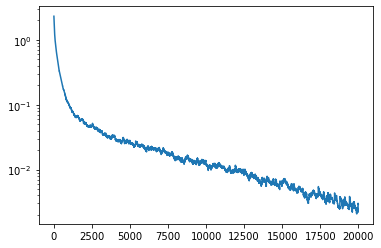

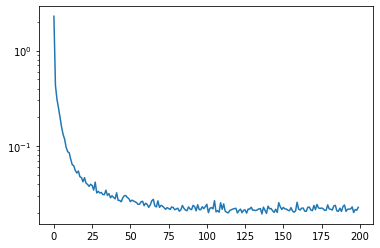

In [13]:
# RMSProp  
step_size = 0.0005
max_mu = 0.99
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for grads**2 estimation 
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_vars = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(grads_vars, grads)]
    new_Ws = [W - step_size*g/tf.sqrt(v + offset) for (W, g, v) in zip(Ws, grads, new_grads_vars)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _,_,_ = sess.run([train_loss, update_Ws, update_grads_vars, update_mu],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs})  
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/rmsprop.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# PSGD with Kronecker Product Preconditioning




train loss: 2.371957302093506; test loss: 2.296251058578491; Time: 0.3235652446746826
train loss: 0.796137183469534; test loss: 0.32205191254615784; Time: 3.826460123062134
train loss: 0.4224137762923683; test loss: 0.12798580527305603; Time: 7.288409233093262
train loss: 0.2143451964974797; test loss: 0.07031036168336868; Time: 10.782591104507446
train loss: 0.11990499198283298; test loss: 0.05237506702542305; Time: 14.260119199752808
train loss: 0.07373242431412833; test loss: 0.0416874922811985; Time: 17.754125833511353
train loss: 0.054110448420727826; test loss: 0.03415646776556969; Time: 21.240963220596313
train loss: 0.04170757578678288; test loss: 0.030097143724560738; Time: 24.72567892074585
train loss: 0.03293952426632383; test loss: 0.028327258303761482; Time: 28.21785020828247
train loss: 0.03121209961056495; test loss: 0.027307581156492233; Time: 31.707183361053467
train loss: 0.02762362571790693; test loss: 0.02620112895965576; Time: 35.20373797416687
train loss: 0.023

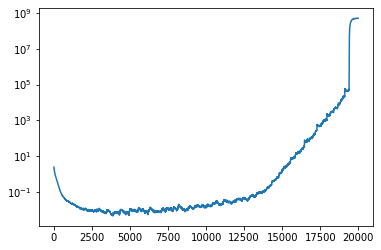

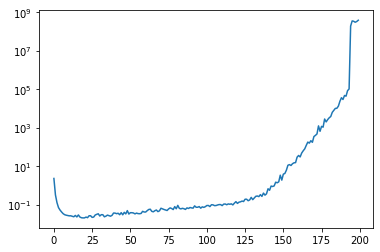

In [14]:
step_size = 0.05
# grad_norm_clip_thr = 1e0 # may be necessary for RNN training; otherwise, set it to an arbitrarily large value or inf  
grad_norm_clip_thr = 1e9
step_size_adjust = 1.0
with tf.Session() as sess:   
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, hess_deltaw)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time': Time})

# PSGD with Kronecker Product Preconditioning (Approximated H*v product)

train loss: 2.333404302597046; test loss: 2.303494930267334, time:0.2723844051361084
train loss: 0.9499027702838184; test loss: 0.4067850112915039, time:3.0507140159606934
train loss: 0.5678733903478763; test loss: 0.28693944215774536, time:5.813530206680298
train loss: 0.3737148788381323; test loss: 0.20974721014499664, time:8.573587894439697
train loss: 0.25767303757840154; test loss: 0.15069185197353363, time:11.313232421875
train loss: 0.18058430697860922; test loss: 0.11326385289430618, time:14.04187536239624
train loss: 0.13266479215388435; test loss: 0.09149836748838425, time:16.777631282806396
train loss: 0.10516099842152275; test loss: 0.076820507645607, time:19.54738211631775
train loss: 0.09068068265732049; test loss: 0.06705618649721146, time:22.286283016204834
train loss: 0.08031339711382333; test loss: 0.060306377708911896, time:25.044039249420166
train loss: 0.07344704133029972; test loss: 0.05401380732655525, time:27.80281901359558
train loss: 0.06352514858001201; test 

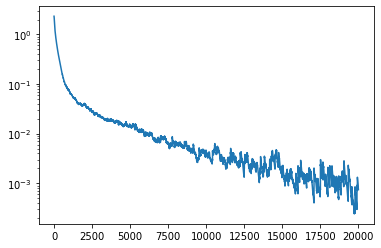

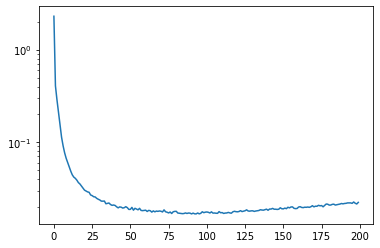

In [15]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_approx.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Kronecker Product + ADAM

train loss: 2.3162622451782227; test loss: 2.3247194290161133, time:0.3129005432128906
train loss: 0.9895605832070115; test loss: 0.36804530024528503, time:3.1904990673065186
train loss: 0.53481568382706; test loss: 0.1984730064868927, time:6.080857515335083
train loss: 0.29986152742722016; test loss: 0.12518467009067535, time:8.967148780822754
train loss: 0.18157977997948177; test loss: 0.08956750482320786, time:11.84916639328003
train loss: 0.12648089372163185; test loss: 0.07110287249088287, time:14.733582019805908
train loss: 0.08948166349431612; test loss: 0.058596424758434296, time:17.61899971961975
train loss: 0.0722151376074206; test loss: 0.05147254467010498, time:20.501386165618896
train loss: 0.0614882457880411; test loss: 0.04536791145801544, time:23.38294506072998
train loss: 0.05406104044459405; test loss: 0.040878526866436005, time:26.23819351196289
train loss: 0.047073166587088905; test loss: 0.03743663802742958, time:29.11343216896057
train loss: 0.04152493704170428; t

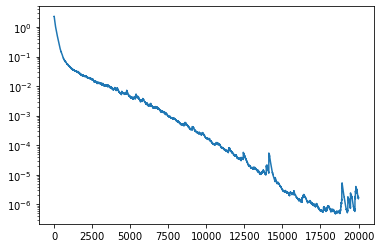

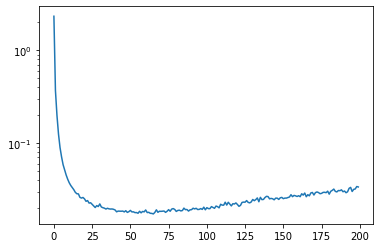

In [16]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    new_grads_moment = [beta1*old + (1.0 - beta1)*new for (old, new) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*old + (1.0 - beta2)*new*new for (old, new) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]

    adam_grads = [m/tf.sqrt(v + offset) for (m,v) in zip(new_grads_moment_hat,new_grads_vars_hat)]

    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, adam_grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws,precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
        t = t + 1
        t0 = time.time()
        _train_loss, _, _,_,_ = sess.run([train_loss, update_Ws, update_Qs,update_grads_moment, update_grads_vars],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step: t})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Comparison of All above second order approximations

In [0]:
sgd = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/SGD.mat')
adam = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/adam.mat')
adam_kron = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_adam.mat')
rmsprop = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/rmsprop.mat')
kron_precond = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond.mat')
kron_precond_approx = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_approx.mat')


In [0]:
sgd_time = sgd.get('Time').reshape(20000,)
adam_time = adam.get('Time').reshape(20000,)
rmsprop_time = rmsprop.get('Time').reshape(20000,)
kron_time =  kron_precond.get('Time').reshape(20000,)
kron_approx_time = kron_precond_approx.get('Time').reshape(20000,)
adam_kron_time = adam_kron.get('Time').reshape(20000,)


In [0]:
sgd_TrainLoss = sgd.get('TrainLoss').reshape(20000,)
adam_TrainLoss = adam.get('TrainLoss').reshape(20000,)
rmsprop_TrainLoss = rmsprop.get('TrainLoss').reshape(20000,)
kron_TrainLoss =  kron_precond.get('TrainLoss').reshape(20000,)
kron_approx_TrainLoss = kron_precond_approx.get('TrainLoss').reshape(20000,)
adam_kron_TrainLoss = adam_kron.get('TrainLoss').reshape(20000,)

In [0]:
sgd_TestLoss = sgd.get('TestLoss').reshape(200,)
adam_TestLoss = adam.get('TestLoss').reshape(200,)
rmsprop_TestLoss = rmsprop.get('TestLoss').reshape(200,)
kron_TestLoss =  kron_precond.get('TestLoss').reshape(200,)
kron_approx_TestLoss = kron_precond_approx.get('TestLoss').reshape(200,)
adam_kron_TestLoss = adam_kron.get('TestLoss').reshape(200,)


In [7]:
optimizers = ['SGD','adam', 'RMSprop', 'kron', 'kron_approx', 'hybrid_ADAMKRON']
training_time = [np.sum(sgd_time),np.sum(adam_time), np.sum(rmsprop_time), np.sum(kron_time),
                 np.sum(kron_approx_time),np.sum(adam_kron_time)]
print(tabulate(zip(optimizers, training_time),headers = ['optimizers','time (sec)']))

optimizers         time (sec)
---------------  ------------
SGD                   212.869
adam                  228.592
RMSprop               216.824
kron                  701.78
kron_approx           549.229
hybrid_ADAMKRON       573.843


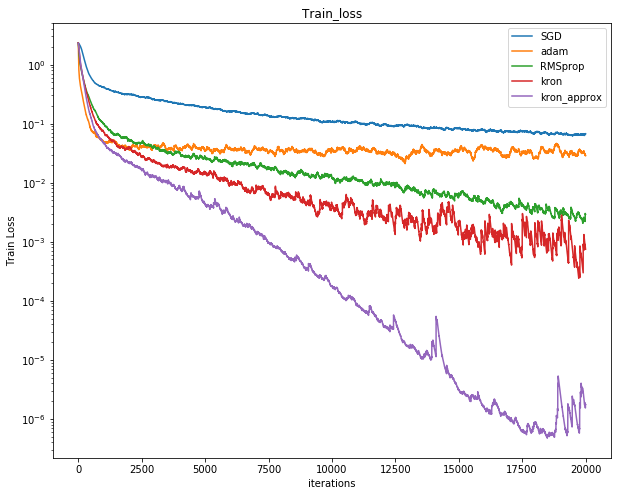

In [13]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TrainLoss)
plt.semilogy(adam_TrainLoss)
plt.semilogy(rmsprop_TrainLoss)
# plt.semilogy(kron_TrainLoss)
plt.semilogy(kron_approx_TrainLoss)
plt.semilogy(adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('iterations')
plt.ylabel('Train Loss')
plt.legend(optimizers)

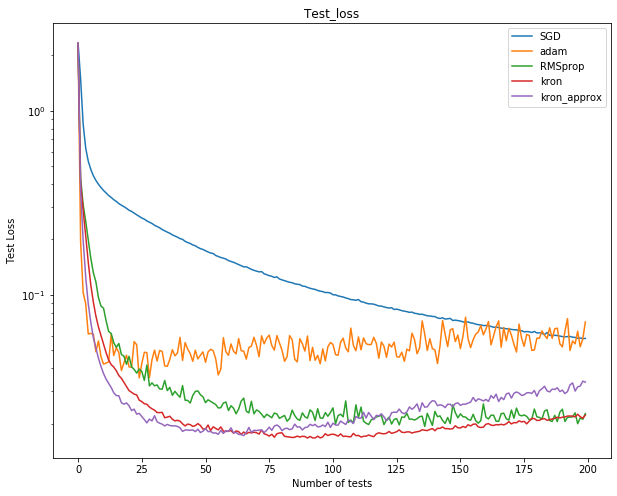

In [12]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TestLoss)
plt.semilogy(adam_TestLoss)
plt.semilogy(rmsprop_TestLoss)
# plt.semilogy(kron_TestLoss)
plt.semilogy(kron_approx_TestLoss)
plt.semilogy(adam_kron_TestLoss)

plt.title('Test_loss')
plt.xlabel('Number of tests')
plt.ylabel('Test Loss')
plt.legend(optimizers)


In [0]:
sgd_t = np.cumsum(sgd_time)
adam_t =  np.cumsum(adam_time)
rmsprop_t = np.cumsum(rmsprop_time)
kron_t =  np.cumsum(kron_time)
kron_approx_t = np.cumsum(kron_approx_time)
adam_kron_t =  np.cumsum(adam_kron_time)

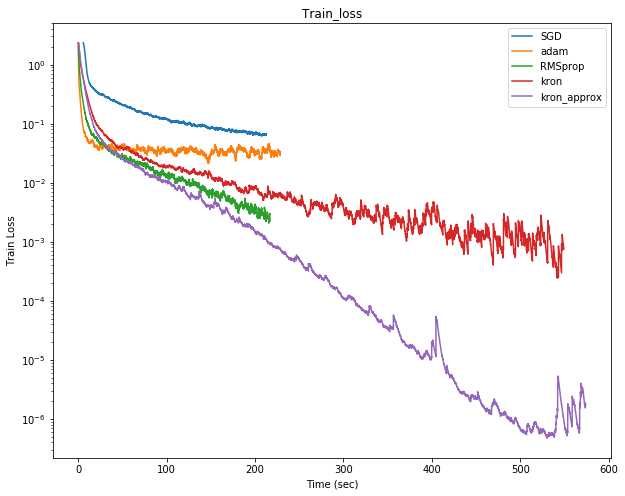

In [16]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_t,sgd_TrainLoss)
plt.semilogy(adam_t,adam_TrainLoss)
plt.semilogy(rmsprop_t,rmsprop_TrainLoss)
# plt.semilogy(kron_t, kron_TrainLoss)
plt.semilogy(kron_approx_t, kron_approx_TrainLoss)
plt.semilogy(adam_kron_t,adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('Time (sec)')
plt.ylabel('Train Loss')
plt.legend(optimizers)
# plt.ylim([0,0.5])